In [131]:
import sagemaker
import boto3
from sagemaker import get_execution_role
import pandas as pd

region = boto3.Session().region_name

session = sagemaker.Session()
bucket = 'lawsnic-aiml-east2'
prefix = 'kaggle/customerChurn'

role = get_execution_role()

sm = boto3.Session().client(service_name='sagemaker',region_name=region)
s3 =  boto3.Session().client(service_name='s3',region_name=region)

train_data_uri = 's3://lawsnic-aiml-east2/kaggle/customerChurn/features/partial/train/CustomerChurnDW-2023-01-06T14-14-13/part-00000-642a0746-49b9-4fda-ad2d-98afe1db11ec-c000.csv'
test_data_uri = 's3://lawsnic-aiml-east2/kaggle/customerChurn/features/partial/test/CustomerChurnDW-2023-01-06T14-14-13/part-00000-ccd6e4dd-898c-4fc4-a63a-85d1cfcfc4dc-c000.csv'
test_data_uri_with_target = 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/test_with_target.csv'

train_data = pd.read_csv(train_data_uri);
test_data = pd.read_csv(test_data_uri);

train_data["SeniorCitizen"] = train_data["SeniorCitizen"].astype(int)
train_data["Churn"] = train_data["Churn"].astype(int)
train_data["Partner"] = train_data["Partner"].astype(int)
train_data["Dependents"] = train_data["Dependents"].astype(int)
train_data["PhoneService"] = train_data["PhoneService"].astype(int)
train_data["PaperlessBilling"] = train_data["PaperlessBilling"].astype(int)
train_data["isFemale"] = train_data["isFemale"].astype(int)
train_data_uri = 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/train.csv'
train_data.to_csv(train_data_uri,index=False)

test_data["SeniorCitizen"] = test_data["SeniorCitizen"].astype(int)
test_data["Churn"] = test_data["Churn"].astype(int)
test_data["Partner"] = test_data["Partner"].astype(int)
test_data["Dependents"] = test_data["Dependents"].astype(int)
test_data["PhoneService"] = test_data["PhoneService"].astype(int)
test_data["PaperlessBilling"] = test_data["PaperlessBilling"].astype(int)
test_data["isFemale"] = test_data["isFemale"].astype(int)
test_data.to_csv('s3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/test_with_target.csv',index=False)

test_data2 =test_data.drop(["Churn"], axis=1)

test_data_uri = 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/test.csv'
test_data2.to_csv(test_data_uri,index=False, header=False)


In [113]:
#train_data.head(10)
#test_data.head(10)
#train_data.columns.to_list()
#test_data.columns.to_list()
#train_data.count('columns')
#test_data.count('columns')

In [9]:
input_data_config = [{
      'DataSource': {
        'S3DataSource': {
          'S3DataType': 'S3Prefix',
          'S3Uri': train_data_uri
        }
      },
      'ChannelType': 'training',    
      'TargetAttributeName': 'Churn'
    }     
  ]

output_data_config = {
    'S3OutputPath': 's3://{}/{}/manual-output/autopilot-en'.format(bucket,prefix)
  }

autoMLJobConfig={
        'CompletionCriteria': {
            'MaxCandidates': 10
        },
        'Mode':'ENSEMBLING'
}

autoMLJobObjective = {
    'MetricName': 'Precision'
}

test_data_s3_path = test_data_uri

Launching the SageMaker Autopilot Job
You can now launch the Autopilot job by calling the create_auto_ml_job API. https://docs.aws.amazon.com/cli/latest/reference/sagemaker/create-auto-ml-job.html

In [10]:
import time

auto_ml_job_name = 'chn' + str(int(time.time()))
print('AutoMLJobName: ' + auto_ml_job_name)

sm.create_auto_ml_job(AutoMLJobName=auto_ml_job_name,
                      InputDataConfig=input_data_config,
                      OutputDataConfig=output_data_config,
                      AutoMLJobConfig=autoMLJobConfig,
                      AutoMLJobObjective=autoMLJobObjective,
                      ProblemType="BinaryClassification",
                      RoleArn=role)

AutoMLJobName: chn1675900555


{'AutoMLJobArn': 'arn:aws:sagemaker:us-east-2:791580863750:automl-job/chn1675900555',
 'ResponseMetadata': {'RequestId': '9ad3df13-490f-438e-89fd-a0b5993f4bba',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9ad3df13-490f-438e-89fd-a0b5993f4bba',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '84',
   'date': 'Wed, 08 Feb 2023 23:55:57 GMT'},
  'RetryAttempts': 0}}

## Tracking SageMaker Autopilot job progress<a name="Tracking"></a>
SageMaker Autopilot job consists of the following high-level steps : 
* Analyzing Data, where the dataset is analyzed and Autopilot comes up with a list of ML pipelines that should be tried out on the dataset. The dataset is also split into train and validation sets.
* Feature Engineering, where Autopilot performs feature transformation on individual features of the dataset as well as at an aggregate level.
* Model Tuning, where the top performing pipeline is selected along with the optimal hyperparameters for the training algorithm (the last stage of the pipeline). 

In [11]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - TrainingModels
InProgress - Tra

## Results

Now use the describe_auto_ml_job API to look up the best candidate selected by the SageMaker Autopilot job. 

In [117]:
#sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)

In [14]:
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
#print(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))



CandidateName: WeightedEnsemble-L2-FULL-t8791580863750chn1675900555
FinalAutoMLJobObjectiveMetricName: Precision
FinalAutoMLJobObjectiveMetricValue: 0.7345971465110779


In [15]:
model_name = 'automl-custChurn-model-' + str(int(time.time()))

model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:us-east-2:791580863750:model/automl-custchurn-model-1676044552


## Clarify

In [120]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.c4.xlarge", sagemaker_session=session
)

### Detecting Bias
SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.
#### Writing DataConfig and ModelConfig
A `DataConfig` object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.

In [121]:
#train_data_uri
#df1 = pd.read_csv(train_data_uri)

In [122]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=bias_report_output_path,
    label="Churn",
    headers=train_data.columns.to_list(),
    dataset_type="text/csv",
)

A `ModelConfig` object specifies how to use your trained model. 
Here you have two options:
1. Specify a model to use using `model_name`, together with`instance_type` and `instance_count`. In this case Clarify will spin up and teardown a **new dedicated endpoint** during the time the processing job is active. This is beneficial for a self-contained mode where the clarify job won't put additional load on an existing endpoint, for example a production endpoint.
2. Specify and `endpoint_name` of an existing endpoint. This has the benefit of **not having to wait** for a new endpoint to spin up, this can help iterate faster during experimentation.

The remaining arguments: `accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint.

In [123]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    accept_type="text/csv",
    #content_type="text/csv",
    instance_type="ml.c5.xlarge",
    instance_count=1,
)

A `ModelPredictedLabelConfig` provides information on the format of your predictions. XGBoost model outputs probabilities of samples, so SageMaker Clarify invokes the endpoint then uses `probability_threshold` to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value `1` and below or equal as label value `0`.

In [124]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

#### Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
SageMaker Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

We specify this information in the `BiasConfig` API. Here that the positive outcome is earning >$50,000, Sex is a sensitive category, and Female respondents are the sensitive group. `group_name` is used to form subgroups for the measurement of Conditional Demographic Disparity in Labels (CDDL) and Conditional Demographic Disparity in Predicted Labels (CDDPL) with regards to Simpson’s paradox.

In [125]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="isFemale"
)

#### Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and help you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

#### Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below.

In [126]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2023-01-31-02-29-35-810
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................................2023-01-31 02:36:14,612 logging.conf not foun

### Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses SHAP to explain the contribution that each input feature makes to the final decision.

Kernel SHAP algorithm requires a baseline (also known as background dataset). If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset. Baseline dataset type shall be the same as `dataset_type` of `DataConfig`, and baseline samples shall only include features. By definition, `baseline` should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the first sample of the test dataset to the list. For example:

In [129]:
#baseline = [test_data.iloc[0].values.tolist()]
#baseline

#can also be
baseline = None

In [131]:
shap_config = clarify.SHAPConfig(
    baseline=baseline,
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_data_uri,
    s3_output_path=explainability_output_path,
    label="Churn",
    headers=train_data.columns.to_list(),
    dataset_type="text/csv",
)

In [132]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2023-01-31-14-57-43-448
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.......................................2023-01-31 15:04:

Example number: 111 
with model prediction: False

Feature values -- Label SeniorCitizen                                0.00
Partner                                      1.00
Dependents                                   1.00
tenure                                       7.00
PhoneService                                 1.00
PaperlessBilling                             0.00
MonthlyCharges                              50.70
TotalCharges                               350.35
Churn                                        0.00
isFemale                                     1.00
MultipleLines_No                             1.00
MultipleLines_Yes                            0.00
MultipleLines_No phone service               0.00
InternetService_Fiber optic                  0.00
InternetService_DSL                          1.00
InternetService_No                           0.00
TechSupport_No                               1.00
TechSupport_Yes                              0.00
TechSupport_No internet s

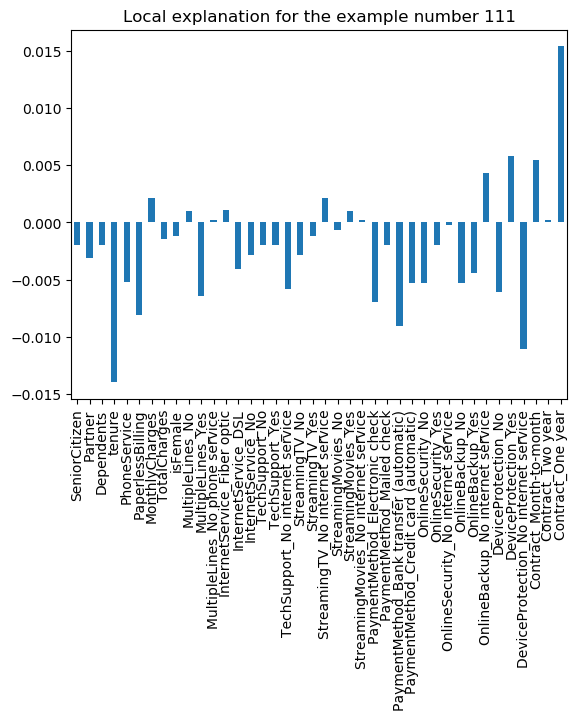

In [136]:
import matplotlib

local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
%matplotlib inline

print("\nFeature values -- Label", train_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

### Perform batch inference using the best candidate

Now that you have successfully completed the SageMaker Autopilot job on the dataset, create a model from any of the candidates by using [Inference Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/inference-pipelines.html). 

In [81]:
from time import gmtime, strftime, sleep 
from sagemaker.inputs import BatchDataCaptureConfig
from sagemaker.model_monitor import DataCaptureConfig
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

transform_job_name = 'automl-custchurn-transform-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                #'S3Uri': test_data_uri
                'S3Uri': test_data_uri
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket,prefix),
        "Accept": "text/csv",
        'AssembleWith': 'Line',
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

data_capture_config = {
       "DestinationS3Uri": 's3://{}/{}/model-monitor/batch-results'.format(bucket,prefix), 
       "GenerateInferenceId": True,
    }

data_proc = { 
        "JoinSource": "Input"
        }
    
transformer = sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources,
                        DataCaptureConfig= data_capture_config,
                        DataProcessing = data_proc
)

In [82]:
print ('JobStatus')
print('----------')


describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(30)

JobStatus
----------
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


In [122]:
s3_output_key = '{}/inference-results/test.csv.out'.format(prefix);
local_inference_results_path = 'inference_results.csv'

s3 = boto3.resource('s3')
inference_results_bucket = s3.Bucket(bucket)

print(s3_output_key)

kaggle/customerChurn/inference-results/test.csv.out


In [123]:
inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

data = pd.read_csv(local_inference_results_path, sep=';')
pd.set_option('display.max_rows', 10)         # Keep the output on one page
data

,"0,0,0,10,0,0,29.75,301.9,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,a7bd4600-e792-4821-9595-078166d65070,2023-02-11T17:41:52Z"
0,"0,0,0,16,1,0,18.95,326.8,0,1.0,0.0,0.0,0.0,0.0..."
1,"0,1,1,10,1,0,55.2,528.35,1,1.0,0.0,0.0,0.0,1.0..."
2,"0,0,1,17,1,1,64.7,1093.1,1,1.0,0.0,0.0,0.0,1.0..."
3,"1,1,0,71,1,1,96.35,6766.95,1,0.0,1.0,0.0,1.0,0..."
4,"1,1,1,60,1,1,74.85,4456.35,1,1.0,0.0,0.0,0.0,1..."
...,...
700,"0,0,0,26,0,0,35.75,1022.5,0,0.0,0.0,1.0,0.0,1...."
701,"0,0,0,38,1,1,95.1,3691.2,0,0.0,1.0,0.0,1.0,0.0..."
702,"0,0,0,51,1,0,20.65,1020.75,1,1.0,0.0,0.0,0.0,0..."
703,"0,1,1,1,1,1,70.65,70.65,0,1.0,0.0,0.0,1.0,0.0,..."


## Model Monitoring
### View captured data from batch inference

In [85]:
s3_client = boto3.Session().client('s3') 
#result = s3_client.list_objects('s3://{}/{}/model-monitor/batch-results'.format(bucket,prefix))
current_endpoint_capture_prefix = '{}/{}'.format(prefix, 'model-monitor/batch-results')
result = s3_client.list_objects(Bucket=bucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
print("Found Capture Files:")
print("\n ".join(capture_files))

Found Capture Files:
kaggle/customerChurn/model-monitor/batch-results/input/2023/02/11/17/683b2caf-8fbe-4eb1-941e-8d466c013339.json
 kaggle/customerChurn/model-monitor/batch-results/output/2023/02/11/17/3a9142cb-a1da-4d72-96e4-854cb3948034.json


### Preview the contents of a capture file

In [86]:
def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

capture_file = get_obj_body(capture_files[-1])
print(capture_file[:2000])

[{"prefix":"s3://lawsnic-aiml-east2/kaggle/customerChurn/inference-results/"},"test.csv.out"]


In [87]:
baseline_prefix = prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)
print('Baseline data uri: {}'.format(baseline_data_uri))
print('Baseline results uri: {}'.format(baseline_results_uri))

Baseline data uri: s3://lawsnic-aiml-east2/kaggle/customerChurn/baselining/data
Baseline results uri: s3://lawsnic-aiml-east2/kaggle/customerChurn/baselining/results


### Create baseline job

In [88]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor_baseline = my_default_monitor.suggest_baseline(
    baseline_dataset=train_data_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True
)


Job Name:  baseline-suggestion-job-2023-02-11-18-05-24-302
Inputs:  [{'InputName': 'baseline_dataset_input', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/clarify/train.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.........................2023-02-11 18:09:25,243 - matplotlib.font_manager - INFO - Generating new fontManager, this may take some time...
2023-02-11 18:09:25.765287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or direc

### Explore generated data

In [89]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Files:")
print("\n ".join(report_files))

Found Files:
kaggle/customerChurn/baselining/results/constraints.json
 kaggle/customerChurn/baselining/results/statistics.json


In [90]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,SeniorCitizen,Integral,6337,0,0.165536,1049.00,0.371663,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,..."
1,Partner,Integral,6337,0,0.484930,3073.00,0.499773,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0,..."
2,Dependents,Integral,6337,0,0.299195,1896.00,0.457905,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,tenure,Integral,6337,0,32.410289,205384.00,24.591410,0.00,72.00,"[{'lower_bound': 0.0, 'upper_bound': 7.2, 'cou...",0.64,2048.0,"[[48.0, 72.0, 7.0, 38.0, 10.0, 30.0, 31.0, 46...."
4,PhoneService,Integral,6337,0,0.903267,5724.00,0.295594,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
5,PaperlessBilling,Integral,6337,0,0.593656,3762.00,0.491150,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0,..."
6,MonthlyCharges,Fractional,6337,0,64.865575,411053.15,30.103892,18.25,118.75,"[{'lower_bound': 18.25, 'upper_bound': 28.3, '...",0.64,2048.0,"[[64.4, 84.9, 19.3, 83.9, 104.4, 74.65, 59.05,..."
7,TotalCharges,Fractional,6327,10,2290.958527,14494894.60,2273.146587,18.80,8684.80,"[{'lower_bound': 18.8, 'upper_bound': 885.4, '...",0.64,2048.0,"[[3255.35, 1067.65, 2065.4, 4136.4, 221.9, 384..."
8,Churn,Integral,6337,0,0.267003,1692.00,0.442394,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
9,isFemale,Integral,6337,0,0.497081,3150.00,0.499991,0.00,1.00,"[{'lower_bound': 0.0, 'upper_bound': 0.1, 'cou...",0.64,2048.0,"[[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0,..."


In [91]:
constraints_df = pd.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
constraints_df.head(10)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,SeniorCitizen,Integral,1.000000,True
1,Partner,Integral,1.000000,True
2,Dependents,Integral,1.000000,True
3,tenure,Integral,1.000000,True
4,PhoneService,Integral,1.000000,True
5,PaperlessBilling,Integral,1.000000,True
6,MonthlyCharges,Fractional,1.000000,True
7,TotalCharges,Fractional,0.998422,True
8,Churn,Integral,1.000000,True
9,isFemale,Integral,1.000000,True


## Analyze collected data for data quality

In [106]:
from sagemaker.model_monitor import CronExpressionGenerator, BatchTransformInput,MonitoringDatasetFormat
from time import gmtime, strftime

SCHEDULE_DESTINATION = "/opt/ml/processing/data" 
 
batch_transform_input=BatchTransformInput(
    data_captured_destination_s3_uri='s3://{}/{}/data-quality'.format(bucket, baseline_results_prefix),
    destination=SCHEDULE_DESTINATION,
    dataset_format=MonitoringDatasetFormat.csv(header=False),
)

s3_report_path = 's3://{}/{}/model-monitor/data-quality/report/'.format(bucket,prefix)
mon_schedule_name = 'smap-churn-model-monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

#my_default_monitor.delete_monitoring_schedule()

my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    #endpoint_input=predictor.endpoint_name,
    #record_preprocessor_script=pre_processor_script,
    #post_analytics_processor_script=s3_code_postprocessor_uri,
    output_s3_uri=s3_report_path,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
    batch_transform_input=batch_transform_input
)


Deleting Monitoring Schedule with name: smap-churn-model-monitor-schedule-2023-02-11-18-44-49


### Inspect schedule

In [107]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Scheduled


In [ ]:
mon_executions = my_default_monitor.list_executions()
print("We created a hourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = my_default_monitor.list_executions()    

### Run through some test data again??

In [ ]:
from time import gmtime, strftime, sleep 
from sagemaker.inputs import BatchDataCaptureConfig
from sagemaker.model_monitor import DataCaptureConfig
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())

transform_job_name = 'automl-custchurn-transform-' + timestamp_suffix

transform_input = {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                #'S3Uri': test_data_uri
                'S3Uri': test_data_uri
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    }

transform_output = {
        'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket,prefix),
        "Accept": "text/csv",
        'AssembleWith': 'Line',
    }

transform_resources = {
        'InstanceType': 'ml.m5.4xlarge',
        'InstanceCount': 1
    }

data_capture_config = {
       "DestinationS3Uri": 's3://{}/{}/model-monitor/batch-results'.format(bucket,prefix), 
       "GenerateInferenceId": True,
    }

data_proc = { 
        "JoinSource": "Input"
        }
    
transformer = sm.create_transform_job(TransformJobName = transform_job_name,
                        ModelName = model_name,
                        TransformInput = transform_input,
                        TransformOutput = transform_output,
                        TransformResources = transform_resources,
                        DataCaptureConfig= data_capture_config,
                        DataProcessing = data_proc
)

In [ ]:
print ('JobStatus')
print('----------')


describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
job_run_status = describe_response['TransformJobStatus']
print (job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName = transform_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print (job_run_status)
    sleep(30)

## Model Quality

In [138]:
from sagemaker.model_monitor import ModelQualityMonitor

model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=session
)

inference_results_bucket.download_file(s3_output_key, local_inference_results_path);

inference_results_pd = pd.read_csv(local_inference_results_path, sep=',', header=None)
pd.set_option('display.max_rows', 10)         # Keep the output on one page

inference_results_pd['Churn'] = test_data['Churn']
inference_results_pd=inference_results_pd.rename(columns={0:'prediction'})

inference_with_groundtruth_data_uri = 's3://lawsnic-aiml-east2/kaggle/customerChurn/model-monitor/model-quality/inference_with_groundtruth.csv'

inference_results_pd.to_csv(inference_with_groundtruth_data_uri, index=False)

In [139]:
baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)

baseline_job_name = "MyBaseLineJob3"
job = model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    #baseline_dataset=baseline_data_uri, # The S3 location of the validation dataset.
    baseline_dataset=inference_with_groundtruth_data_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri = baseline_results_uri, # The S3 location to store the results.
    problem_type='BinaryClassification',
    inference_attribute= "prediction", # The column in the dataset that contains predictions.
    #probability_attribute= "probability", # The column in the dataset that contains probabilities.
    ground_truth_attribute= "Churn" # The column in the dataset that contains ground truth labels.
)
job.wait(logs=False)


Job Name:  MyBaseLineJob3
Inputs:  [{'InputName': 'baseline_dataset_input', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/model-monitor/model-quality/inference_with_groundtruth.csv', 'LocalPath': '/opt/ml/processing/input/baseline_dataset_input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'monitoring_output', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://lawsnic-aiml-east2/kaggle/customerChurn/baselining/results', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..........................2023-02-11 20:07:09,720 - matplotlib.font_manager - INFO - Generating new fontManager, this may take some time...
2023-02-11 20:07:10.241076: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file

In [140]:
baseline_job = model_quality_monitor.latest_baselining_job

In [141]:
import pandas as pd
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.20904,LessThanThreshold
precision,0.397849,LessThanThreshold
accuracy,0.72238,LessThanThreshold
true_positive_rate,0.20904,LessThanThreshold
true_negative_rate,0.89414,LessThanThreshold
false_positive_rate,0.10586,GreaterThanThreshold
false_negative_rate,0.79096,GreaterThanThreshold
f0_5,0.336976,LessThanThreshold
f1,0.274074,LessThanThreshold
f2,0.230961,LessThanThreshold
